In [1]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt 
from astropy.cosmology import FlatLambdaCDM

In [2]:
# Some preliminary stuff
H0, Om0 = 70.0, 0.308
q0 = 3.0*Om0/2.0 - 1.0
LightSpeed = 299792.458
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
red_array = np.linspace(0.0, 1.0, 500)
dist_array = cosmo.comoving_distance(red_array).value
red_spline, dist_spline = sp.interpolate.splrep(dist_array, red_array), sp.interpolate.splrep(red_array, dist_array)

In [3]:
# Generate a uniform distribution of galaxies with some distance, cosmological redshift, PV and observed redshift
ngals, zmin, zmax = 100000, 0.0, 0.10
dmin, dmax = sp.interpolate.splev(zmin, dist_spline), sp.interpolate.splev(zmax, dist_spline)
distances = (dmax-dmin)*np.random.rand(ngals) + dmin
vels = np.random.normal(0.0, 1000.0, ngals)
z_H = sp.interpolate.splev(distances, red_spline)
z_obs = (1.0 + z_H)*(1.0 + vels/LightSpeed) - 1.0

In [4]:
# Cut out galaxies with negative observed redshift
index = np.where(z_obs > 0.0)
ngals = len(index[0])
distances = distances[index]
vels = vels[index]
z_H = z_H[index]
z_obs = z_obs[index]
dz = sp.interpolate.splev(z_obs, dist_spline)
deltad = np.log10(dz/distances)

In [5]:
# Give them all sizes drawing from the FP
a, b, rmean, smean, imean, sigma1, sigma2, sigma3 = 1.177, -0.793, 0.165, 2.102, 2.653, 0.059, 0.392, 0.256
sigmar2 = 1.0/(1.0+a**2+b**2)*sigma1**2 + b**2/(1.0+b**2)*sigma2**2 + a**2/((1.0+b**2)*(1.0+a**2+b**2))*sigma3**2
sigmas2 = a**2/(1.0+a**2+b**2)*sigma1**2 + (1.0+b**2)/(1.0+a**2+b**2)*sigma3**2
sigmai2 = b**2/(1.0+a**2+b**2)*sigma1**2 + 1.0/(1.0+b**2)*sigma2**2 + a**2*b**2/((1.0+b**2)*(1.0+a**2+b**2))*sigma3**2
sigmars = -a/(1.0+a**2+b**2)*sigma1**2 + a*(1.0+b**2)/((1.0+b**2)*(1.0+a**2+b**2))*sigma3**2
sigmari = -b/(1.0+a**2+b**2)*sigma1**2 + b/(1.0+b**2)*sigma2**2 - a**2*b/((1.0+b**2)*(1.0+a**2+b**2))*sigma3**2
sigmasi = a*b/(1.0+a**2+b**2)*sigma1**2 - a*b/(1.0+a**2+b**2)*sigma3**2
cov = np.array([[sigmar2, sigmars, sigmari], [sigmars, sigmas2, sigmasi], [sigmari, sigmasi, sigmai2]])
means = np.array([rmean, smean, imean])
fptrue = np.random.multivariate_normal(means, cov, ngals)

In [6]:
# Now add constant "measurement errors"
err_r = np.zeros(ngals)+0.007
err_s = np.zeros(ngals)+0.015
err_i = np.zeros(ngals)+0.015
fpmeasure = np.empty((ngals,3))
for i in range(ngals):
	err_cov = np.array([[err_r[i]**2 + np.log10(1.0 + 300.0/(LightSpeed*z_obs[i]))**2, 0.0, -1.0*err_r[i]*err_i[i]], [0.0, err_s[i]**2, 0.0], [-1.0*err_r[i]*err_i[i], 0.0, err_i[i]**2]])
	fpmeasure[i,:] = np.random.multivariate_normal(fptrue[i,:], err_cov)


In [7]:
# Convert to observables
angularsize = fpmeasure[:,0] - np.log10(dz/(1.0 + z_obs)) - np.log10(1000.0*np.pi/(180.0*3600.0))  # This is the angular size we observe for the galaxy including the PV
fpfit = a * (fpmeasure[:,1] - smean) + b * (fpmeasure[:,2] - imean) + rmean                        # This is the effective size we think the galaxy should have based on the FP

In [8]:
# Now compute the Hubble diagram
muA = fpfit - angularsize - np.log10(1000.0*np.pi/(180.0*3600.0))
muA_deltad = fpfit - angularsize - np.log10(1000.0*np.pi/(180.0*3600.0)) - deltad

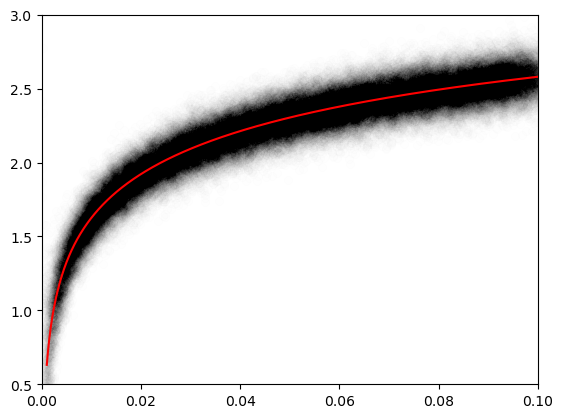

In [10]:
zplot = np.linspace(1.0e-3, zmax, 1000)
plt.figure()
plt.errorbar(z_obs, muA, marker='o', color='k', ls='None', alpha=0.002, zorder=1)
plt.plot(zplot, np.log10(sp.interpolate.splev(zplot, dist_spline)/(1.0+zplot)), color='r', ls='-', marker='None', zorder=5)
plt.xlim(0.0, 0.1)
plt.ylim(0.5, 3.0)
plt.show()

In [11]:
muA_model_approx = np.log10(LightSpeed * z_obs * (1.0 + 0.5*(1.0 - q0)*z_obs) - 1.0/6.0*(1.0 - q0 - 3.0*q0**2 + 1.0)*z_obs**2) - np.log10(70.0) - 2.0*np.log10(1.0 + z_obs)
mudiff = muA - muA_model_approx
binned_mudiff, mubins, _ = sp.stats.binned_statistic(z_obs, mudiff, statistic='mean', bins=np.linspace(0.0, zmax, 31))
binned_mudiff_err = sp.stats.binned_statistic(z_obs, mudiff, statistic='std', bins=np.linspace(0.0, zmax, 31))[0]
binned_mudiff_counts = sp.stats.binned_statistic(z_obs, mudiff, statistic='count', bins=np.linspace(0.0, zmax, 31))[0]
mubins = (mubins[1:] + mubins[:-1])/2.0

mudiff_deltad = muA_deltad - muA_model_approx
binned_mudiff_deltad, _, _ = sp.stats.binned_statistic(z_obs, mudiff_deltad, statistic='mean', bins=np.linspace(0.0, zmax, 31))
binned_mudiff_err_deltad = sp.stats.binned_statistic(z_obs, mudiff_deltad, statistic='std', bins=np.linspace(0.0, zmax, 31))[0]
binned_mudiff_counts_deltad = sp.stats.binned_statistic(z_obs, mudiff_deltad, statistic='count', bins=np.linspace(0.0, zmax, 31))[0]

muA_model = np.log10(sp.interpolate.splev(z_obs, dist_spline)/(1.0 + z_obs))
mudiff_true = muA - muA_model
binned_mudiff_true, _, _ = sp.stats.binned_statistic(z_obs, mudiff_true, statistic='mean', bins=np.linspace(0.0, zmax, 31))
binned_mudiff_err_true = sp.stats.binned_statistic(z_obs, mudiff_true, statistic='std', bins=np.linspace(0.0, zmax, 31))[0]
binned_mudiff_counts_true = sp.stats.binned_statistic(z_obs, mudiff_true, statistic='count', bins=np.linspace(0.0, zmax, 31))[0]

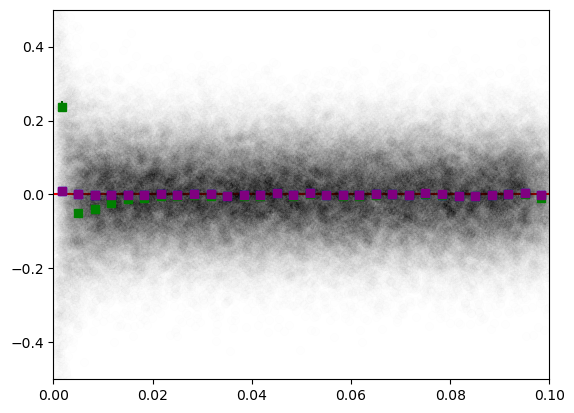

In [12]:
plt.figure()
plt.errorbar(z_obs, mudiff, marker='o', color='k', ls='None', alpha=0.002)
plt.errorbar(mubins, binned_mudiff, binned_mudiff_err/np.sqrt(binned_mudiff_counts), color='b', marker='s', ls='None')
plt.errorbar(mubins, binned_mudiff_deltad, binned_mudiff_err_deltad/np.sqrt(binned_mudiff_counts_deltad), color='g', marker='s', ls='None')
plt.errorbar(mubins, binned_mudiff_true, binned_mudiff_err_true/np.sqrt(binned_mudiff_counts_true), color='purple', marker='s', ls='None')
plt.xlim(0.0, 0.1)
plt.ylim(-0.5, 0.5)
plt.axhline(y=0.0, color='r')
plt.show()